# Abstract

In this notebook, I will focus on an approach that suggested by Victor Lo. He was suggesting using the dummy variable to decide whether a customer will be given a promo or not. By comparing the model results and substract them and then if the result is above certain threshold it will be flagged as prospectus customer, otherwise if customer below certain threshold it won't be targetted to customer promos. The Victor Lo presentation: [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation)

# Portfolio Exercise: Starbucks
<br>
<br>
<img src="http://www.pngmart.com/files/3/Starbucks-Logo-PNG-File.png" width="200" height="200">
<br>
<br>

## Background Information

The dataset that will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at **10 bucks** . Since it costs the company **0.15 bucks** to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

## Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 Dollar times the total number of purchasers that received the promotion minus 0.15 Dollar times the number of promotions sent out, minus 10 Dollar times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below we can find the training data provided.  Explore the data and different optimization strategies.

## How To Test Your Strategy?

When we feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

# The Analytical Steps.

## Import and variables

In [5]:
# load in packages
from itertools import combinations

from test_results import valid_results, test_results, score
from IPython.display import Image
from IPython.core.display import HTML 

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [9]:
# load in the data
train_data = pd.read_csv('./training.csv')
# train_data.head()
test_data = pd.read_csv('./Test.csv')
# test_data.head(7)

In [10]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [11]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [12]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

## EDA

## Training | Promotion and Purchase

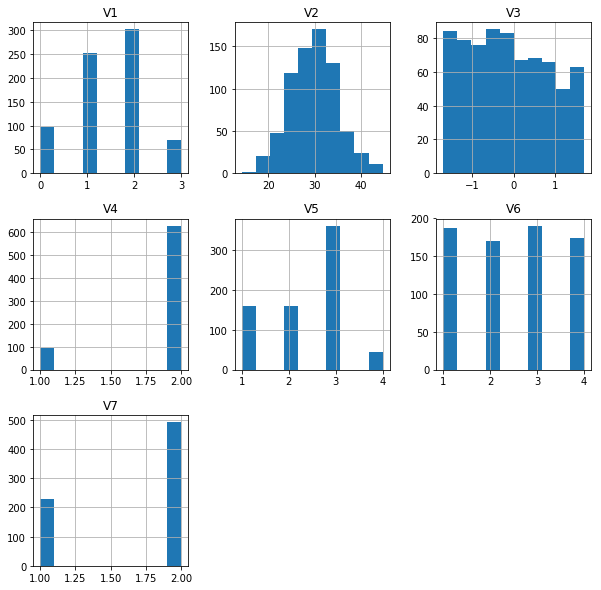

In [13]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

## Promotion and Purchase-not

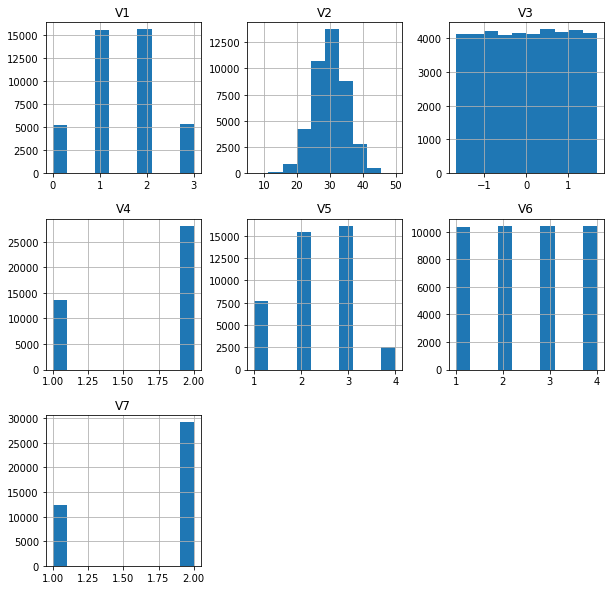

In [10]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

## Promotion-not and Purchase

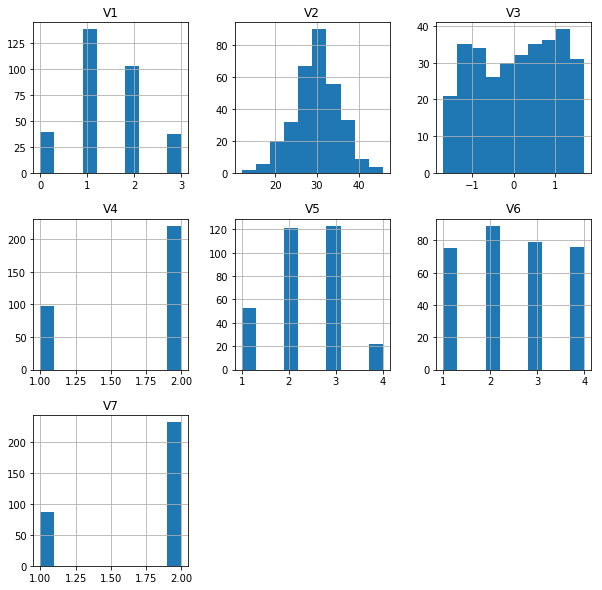

In [11]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

## Promotion-not and Purchase-not

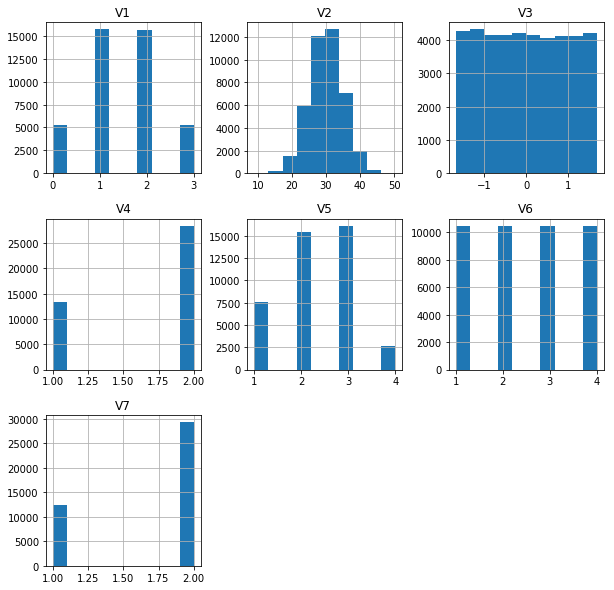

In [12]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

In [17]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [25]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

In [26]:
# Check sample size needed for control and treatment groups
NormalIndPower().solve_power(effect_size = proportion_effectsize(.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

In [27]:
# calculate our current treatment group size
train_data[train_data['Promotion']=='Yes'].shape[0]

42364

In [28]:
# calculate our current control group size
train_data[train_data['Promotion']=='No'].shape[0]

42170

If we were to send everyone a promotion, our IRR is 0.96\% and NIR is -\\$1,132.20. This will be the baseline model. Hence, blindly sending everyone a promotion is going to lose the company a lot of money.

Our baseline IRR is 0.096\%. If our desired minimum IRR is 1.5\% (an 0.081\% absolute increase in IRR), and we want to detect this change with a type 1 error rate of 0.05 and a power of 0.80, we will need a sample size of approximately 5,090 in each group (both control and treatment). Since, we have more than 40,000 data points in each group, we have sufficient data

# An approach: Using Treatment Dummy Approach

In this approach, a single model is used to model the data. Unlike the approach used in the first model, this approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group. 

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):

$$Lift = P(purchase | I_{treat} = 1) - P(purchase |  I_{treat} = 0)$$

We can opt to send promotions to individuals with prostive lift values. Using this approach for this dataset, an irr of 1.42\% and an nlr of -\\$47.40 is obtained for the validation set. On the other hand, the irr and nlr values for the test set is 1.54\% and \\$42.60 respectively. Such a drastic difference between the validation and test nlrs is certainly surprising. The test results does seem to suggest that this is could be a relatively good approach as well. Alternative models, new feature generation and alternative upsampling methods could be tried to improve the results. In addition, you can also choose to send promotions only to individuals with lift values above a certain percentile.

This approach is a slight modification of the method proposed by Victor Lo in the previously mentioned presentation, which can be found [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). The original method proposes a logistic regression model.

In [14]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [15]:
# encode Promotion as 0 or 1 indicator variable
train_data['treatment'] = np.where(train_data['Promotion'] == "Yes", 1, 0)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [16]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'treatment']

Y_train = train['purchase']
X_train = train[features]

Y_valid = valid['purchase']
X_valid = valid[features]

In [17]:
# up sample with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [18]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.916298	validation_1-auc:0.654634
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.919459	validation_1-auc:0.660875
[2]	validation_0-auc:0.928347	validation_1-auc:0.654825
[3]	validation_0-auc:0.932595	validation_1-auc:0.645971
[4]	validation_0-auc:0.935008	validation_1-auc:0.647883
[5]	validation_0-auc:0.934159	validation_1-auc:0.646341
[6]	validation_0-auc:0.937256	validation_1-auc:0.641421
[7]	validation_0-auc:0.943894	validation_1-auc:0.641898
[8]	validation_0-auc:0.947674	validation_1-auc:0.641579
[9]	validation_0-auc:0.951958	validation_1-auc:0.642712
[10]	validation_0-auc:0.953071	validation_1-auc:0.640663
[11]	validation_0-auc:0.955449	validation_1-auc:0.639448
[12]	validation_0-auc:0.956925	validation_1-auc:0.638436
[13]	validation_0-auc:0.95936	validation_1-auc:0.639407
[14]	validation_0-auc:0.960672	validation_1-auc:0.63744


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

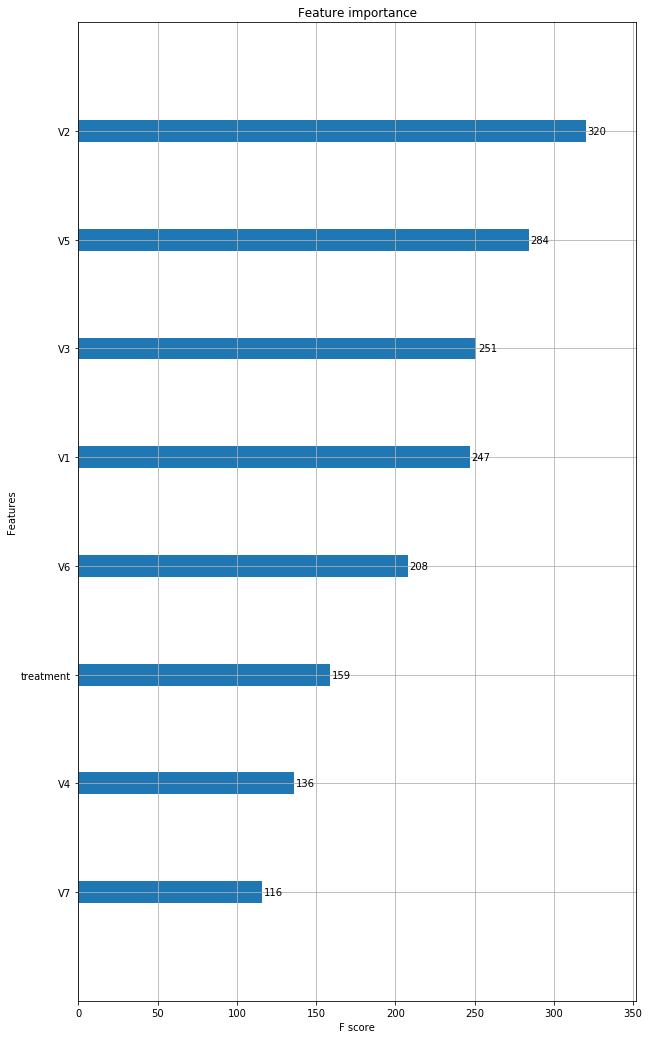

In [19]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

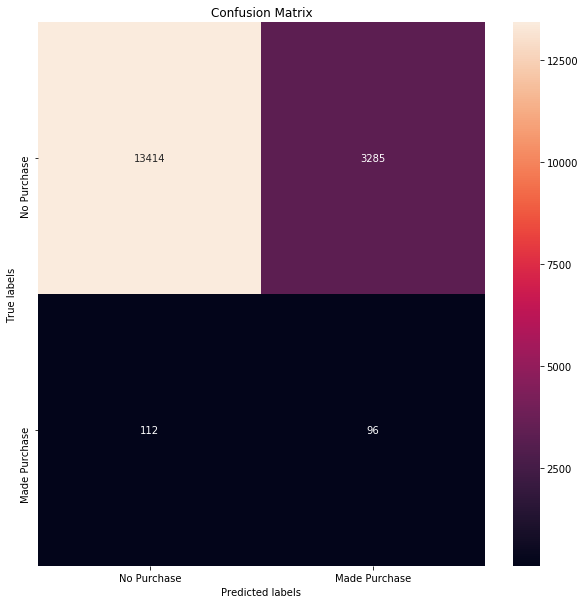

In [20]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [21]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [22]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Nice job!  See how well your strategy worked on our valid data below!

Your irr with this strategy is 0.0142.

Your nir with this strategy is -47.40.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.014177323450404136, -47.39999999999998)

In [23]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0154.

Your nir with this strategy is 42.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.015416668070903982, 42.59999999999991)